# Grovers Algorithmus

In diesem Abschnitt stellen wir den Grover-Algorithmus vor und wie er verwendet werden kann, um unstrukturierte Suchprobleme zu lösen. Wir implementieren dann den Grover-Algorithmus mit Qiskit und wenden diesen auf tatsächliche Probleme an, welche auf einem Simulator und einem tatsächlichen Gerät gelöst werden.

## Inhalt

1.  [Einführung](#introduction)
     1.1 [Algorithmusübersicht](#overview)
     1.2 [Grover Schritt für Schritt](#steps)
     1.3 [Zustand Vorbereitung](#state-prep)
     1.4 [Das Orakel](#oracle)
     1.5 [Der Diffusionsoperator](#diffusion)
2. [Beispiel: 2 Qubits](#2qubits)
     2.1 [Simulation](#2qubits-simulation)
     2.2 [Gerät](#2qubits-device)
3. [Beispiel: 3 Qubits](#3qubits)
     3.1 [Simulation](#3qubits-simulation)
     3.2 [Gerät](#3qubits-device)
4. [Probleme](#problems)
     4.1 [Sudoku mit Grovers Algorithmus lösen](#sudoku)
     4.2 [Lösen des Dreiecksproblems mit dem Grover-Algorithmus](#tri)
5. [Verweise](#references)


## 1. Einleitung<a id="introduction"></a>

Sie haben wahrscheinlich gehört, dass einer der vielen Vorteile, die ein Quantencomputer gegenüber einem klassischen Computer hat, seine überlegene Geschwindigkeit beim Durchsuchen von Datenbanken ist. Grovers Algorithmus demonstriert diese Fähigkeit. Dieser Algorithmus kann ein unstrukturiertes Suchproblem quadratisch beschleunigen, aber seine Verwendung geht darüber hinaus; Es kann als allgemeiner Trick oder Unterprogramm dienen, um quadratische Laufzeitverbesserungen für eine Vielzahl anderer Algorithmen zu erhalten. Dies wird als Amplitudenverstärkungstrick bezeichnet.

Angenommen, Sie erhalten eine große Liste mit $N$-Elementen. Unter diesen Gegenständen gibt es einen Gegenstand mit einer einzigartigen Eigenschaft, den wir ausfindig machen möchten; wir nennen dies den Gewinner $w$. Stellen Sie sich jedes Element in der Liste als Kästchen in einer bestimmten Farbe vor. Angenommen, alle Elemente in der Liste sind grau, außer dem Gewinner $w$, der lila ist.

![Bild1](images/grover_list.png)

Um das violette Kästchen – den *markierten Gegenstand* – mit klassischer Berechnung zu finden, müsste man durchschnittlich $N/2$ dieser Kästchen ankreuzen, und im schlimmsten Fall alle $N$ davon. Auf einem Quantencomputer hingegen können wir mit Grovers Amplitudenverstärkungstrick das markierte Objekt in etwa $\sqrt{N}$ Schritten finden. Eine quadratische Beschleunigung ist in der Tat eine erhebliche Zeitersparnis beim Auffinden markierter Elemente in langen Listen. Außerdem verwendet der Algorithmus nicht die interne Struktur der Liste, was ihn *generisch macht;* Aus diesem Grund liefert er für viele klassische Probleme sofort eine quadratische Quantenbeschleunigung.


### 1.1 Algorithmusübersicht<a id="overview"></a>

Grovers Algorithmus besteht aus drei Hauptalgorithmusschritten: Zustandsvorbereitung, Orakel und Diffusionsoperator. In der Zustandsvorbereitung schaffen wir den Suchraum, der alle möglichen Fälle umfasst, die die Antwort annehmen könnte. In dem oben erwähnten Listenbeispiel würde der Suchraum alle Elemente dieser Liste umfassen.
 Das Orakel markiert die richtige Antwort oder Antworten, nach denen wir suchen, und der Diffusionsoperator vergrößert diese Antworten, damit sie am Ende des Algorithmus herausstechen und gemessen werden können.

![Bild2](images/grover_steps.png)

Wie funktioniert der Algorithmus? Bevor wir uns die Liste der Elemente ansehen, wissen wir nicht, wo sich das markierte Element befindet. Daher ist jede Vermutung seines Ortes so gut wie jede andere, was durch eine einheitliche Superposition ausgedrückt werden kann: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0} ^{N-1} | x \rangle.$

Wenn wir an dieser Stelle in der Standardbasis $ { | x \rangle } $ messen würden, würde diese Superposition nach dem fünften Quantengesetz mit der gleichen Wahrscheinlichkeit $\frac{1}{N} = \frac{1}{2^n}$ in jeden der Basiszustände kollabieren. Unsere Chancen, den richtigen Wert $w$ zu erraten, sind daher $1$ in $2^n$, wie zu erwarten war. Daher müssten wir im Durchschnitt etwa $N/2 = 2^{n-1}$ Versuche machen, um das richtige Element zu erraten.

Geben Sie das Verfahren namens Amplitudenverstärkung ein, mit dem ein Quantencomputer diese Wahrscheinlichkeit erheblich erhöht. Dieses Verfahren dehnt (verstärkt) die Amplitude des markierten Elements aus, wodurch die Amplitude der anderen Elemente verringert wird, sodass die Messung des Endzustands mit ziemlicher Sicherheit das richtige Element zurückgibt.

Dieser Algorithmus hat eine schöne geometrische Interpretation in Bezug auf zwei Reflexionen, die eine Drehung in einer zweidimensionalen Ebene erzeugen. Die einzigen zwei Sonderzustände, die wir berücksichtigen müssen, sind der Gewinner $| w \rangle$ und der gleichmäßigen Superpositionszustand $| s\rangle$. Diese beiden Vektoren spannen eine zweidimensionale Ebene im Vektorraum $\cssId{vspace}{\mathbb{C}^N}$ auf. Sie sind nicht ganz senkrecht, weil $| w \rangle$ kommt auch in der Überlagerung mit der Amplitude $N^{-1/2}$ vor. Wir können jedoch einen zusätzlichen Zustand $|s'\rangle$ einführen, der in der Spanne dieser beiden Vektoren liegt, welcher senkrecht zu $| w \rangle$ ist und durch Entfernen von $| w \rangle$ aus $|s \rangle$ erhalten und neuskaliert wird.

**Schritt 1** : Der Vorgang der Amplitudenverstärkung beginnt in der gleichmäßigen Überlagerung $| s \rangle$, das sich leicht aus $| s \rangle = H^{\otimes n} | 0 \rangle^n$ konstruieren lässt  oder mit anderen symmetrisch verschränkten Zuständen.

![Bild3](images/grover_step1.jpg)

Die linke Grafik entspricht der zweidimensionalen Ebene, die von den senkrechten Vektoren $|w\rangle$ und $|s'\rangle$ aufgespannt wird, was es erlaubt, den Anfangszustand als $|s\rangle = \sin \theta | auszudrücken w \rangle + \cos\theta | s' \rangle,$ wobei $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. Die rechte Grafik ist ein Balkendiagramm der Amplituden des Zustands $| s\rangle$.

**Schritt 2** : Wir wenden die Orakelreflexion $U_f$ auf den Zustand $|s\rangle$ an.

![Bild4](images/grover_step2.jpg)

Geometrisch entspricht dies einer Spiegelung des Zustands $|s\rangle$ an $|s'\rangle$. Diese Transformation bedeutet, dass die Amplitude vor dem $|w\rangle$-Zustand negativ wird, was wiederum bedeutet, dass die durchschnittliche Amplitude (gestrichelt angedeutet) abgesenkt wurde.

**Schritt 3** : Wir wenden nun eine zusätzliche Reflexion ($U_s$) über den Zustand $|s\rangle$ an: $U_s = 2|s\rangle\langle s| - \mathbb{1}$. Diese Transformation bildet den Zustand auf $U_s U_f| s \rangle$ ab und vervollständigt die Transformation.

![Bild5](images/grover_step3.jpg)

Zwei Spiegelungen entsprechen immer einer Drehung. Die Transformation $U_s U_f$ dreht den Anfangszustand $|s\rangle$ näher zum Gewinner $|w\rangle$. Die Wirkung der Reflexion $U_s$ im Amplituden-Balkendiagramm kann als Reflexion über die mittlere Amplitude verstanden werden. Da die mittlere Amplitude durch die erste Reflexion abgesenkt wurde, hebt diese Transformation die negative Amplitude von $|w\rangle$ auf etwa das Dreifache ihres ursprünglichen Wertes an, während sie die anderen Amplituden absenkt. Wir gehen dann zu **Schritt 2** , um die Anwendung zu wiederholen. Dieser Vorgang wird mehrmals wiederholt, um den Gewinner zu ermitteln.

Nach $t$ Schritten befinden wir uns im Zustand $|\psi_t\rangle$ wo: $| \psi_t \rangle = (U_s U_f)^t | s \rangle.$

Wie oft müssen wir die Rotation anwenden? Es stellt sich heraus, dass ungefähr $\sqrt{N}$ Rotationen ausreichen. Dies wird deutlich, wenn man sich die Amplituden des Zustands $|\psi\rangle$ anschaut. Wir können sehen, dass die Amplitude von $| w \rangle$ linear mit der Anzahl der Anwendungen $\sim t N^{-1/2}$ wächst. Da wir es jedoch mit Amplituden und nicht mit Wahrscheinlichkeiten zu tun haben, tritt die Dimension des Vektorraums als Quadratwurzel ein. Daher wird bei diesem Verfahren die Amplitude und nicht nur die Wahrscheinlichkeit verstärkt.

Um die Anzahl der Rotationen zu berechnen, müssen wir die Größe des Suchraums und die Anzahl der gesuchten Antworten kennen. Um die optimale Anzahl von Iterationen $t$ zu erhalten, können wir der Gleichung folgen:

$$ t = \lfloor\frac{\pi}{4}\sqrt{\frac{N}{m}}\rfloor $$

Wobei N die Größe des Suchraums und m die Anzahl der gewünschten Antworten ist.

![Bild6](images/grover_circuit_high_level.png)

 

## 1.2 Grover Schritt für Schritt<a id="step"></a>

Nachdem wir uns nun angesehen haben, wie Grovers Algorithmus tatsächlich funktioniert, gehen auf die Konstruktion und die verschiedenen Fälle für jede seiner Komponenten tiefer ein.

## 1.2.1 Vorbereiten des Suchraums<a id="state-prep"></a>

Der erste Schritt des Grover-Algorithmus ist die anfängliche Zustandsvorbereitung. Wie wir gerade erwähnt haben, umfasst der Suchraum alle möglichen Werte, die wir durchsuchen müssen, um die gewünschte Antwort zu finden. Für die Beispiele in diesem Lehrbuch besteht unsere „Datenbank“ aus allen möglichen Rechenbasiszuständen, in denen sich unsere Qubits befinden können. Wenn wir beispielsweise 3 Qubits haben, besteht unsere Liste aus den Zuständen $|000\rangle, |001\rangle , \dots |111\rangle$ (also die Zustände $|0\rangle \rightarrow |7\rangle$). In diesem Fall ist die Größe unseres Suchraums also $N = 2^{3} = 8$.

Wenn wir den Bereich innerhalb des Suchraums kennen, in dem die Antwort garantiert ist, können wir in einigen Fällen die redundante Basis aus unserem Suchraum eliminieren, um den Algorithmus zu beschleunigen und die Größe der Schaltung zu verringern. Im Allgemeinen können wir unseren Zustand unter Verwendung beliebiger [symmetrischer Zustände](gloss:ss) wie [GHZ-Zustände](https://quantum-computing.ibm.com/composer/docs/iqx/example-circuits/ghz) , [W-Zustände](https://quantum-computing.ibm.com/composer/docs/iqx/example-circuits/w-state) oder [Dicke-Zustände](gloss:ds) präparieren.

Wenn wir beispielsweise versuchen, ein Problem mit einer Antwort unter Verwendung von 4 Qubits zu lösen, und wir unseren Zustand mithilfe des Hadamard-Gatters vorbereiten (dh den Hilbert-Raum bilden), ist N 16. Aber wenn wir wissen, dass die Antwort innerhalb ist Zustände, wenn immer nur ein Qubit den Wert 1 hat, können wir dann den W-Zustand anstelle des vollen Hilbert-Raums verwenden, um unsere Zustände vorzubereiten. Dadurch wurde die Größe des Suchraums von 16 auf 4 und die Anzahl der optimalen Iterationen $t$ von 3 auf 1 verringert.

## 1.2.2 Erstellen des Orakels<a id="oracle"></a>

Der zweite und wichtigste Schritt von Grovers Algorithmus ist das Orakel. Orakel fügen den Lösungszuständen eine negative Phase hinzu, damit sie sich vom Rest abheben und gemessen werden können. Dh für jeden Zustand $|x\rangle$ in der Berechnungsbasis:

$$ U_\omega|x\rangle = \bigg{ \begin{aligned} \phantom{-}|x\rangle \quad \text{if} ; x\neq\omega\-|x\rangle\quad\text{if} ; x = \omega \ \end{aligned} $$

Dieses Orakel ist eine diagonale Matrix, in der der Eintrag, der dem markierten Element entspricht, eine negative Phase hat. Wenn wir beispielsweise drei Qubits und $\omega = \text{101}$ haben, hat unser Orakel die Matrix:

$$ U_\omega = \begin{bmatrix} 1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \ 0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \ 0 &amp; 0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \ 0 &amp; 0 &amp; 0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \ 0 &amp; 0 &amp; 0 &amp; 0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 \ 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; -1 &amp; 0 &amp; 0 \ 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 1 &amp; 0 \ 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 1 \ \end{bmatrix} \begin{aligned} \ \ \ \ \ \ \leftarrow \omega = \text{101}\ \ \ \ \end{aligned} $$

Was Grovers Algorithmus so leistungsfähig macht, ist, wie einfach es ist, ein Problem in ein Orakel dieser Form umzuwandeln. Es gibt viele Rechenprobleme, bei denen es schwierig ist, eine Lösung zu *finden* , aber relativ einfach, eine Lösung zu *verifizieren* . Zum Beispiel können wir eine Lösung für ein [Sudoku](https://en.wikipedia.org/wiki/Sudoku) leicht überprüfen, indem wir überprüfen, ob alle Regeln erfüllt sind. Für diese Probleme können wir eine Funktion $f$ erstellen, die eine vorgeschlagene Lösung $x$ nimmt und $f(x) = 0$ zurückgibt, wenn $x$ keine Lösung ist ($x \neq \omega$) und $ f(x) = 1$ für eine gültige Lösung ($x = \omega$). Unser Orakel kann dann beschrieben werden als:

$$ U_\omega|x\rangle = (-1)^{f(x)}|x\rangle $$

und die Matrix des Orakels wird eine diagonale Matrix der Form sein:

$$ U_\omega = \begin{bmatrix} (-1)^{f(0)} &amp; 0 &amp; \cdots &amp; 0 \ 0 &amp; (-1)^{f(1)} &amp; \cdots &amp; 0 \ \ vdots &amp; 0 &amp; \ddots &amp; \vdots \ 0 &amp; 0 &amp; \cdots &amp; (-1)^{f(2^n-1)} \ \end{bmatrix} $$

<!-- ::: q-block.reminder -->

### Detail

<summary>Schaltungsaufbau eines Grover-Orakels</summary><p> Wenn wir unsere klassische Funktion $f(x)$ haben, können wir sie in eine umkehrbare Schaltung der Form umwandeln:</p>
<p></p>
<img alt="Ein klassisches ewiges Orakel" src="images/grover_boolean_oracle.svg"><p> Wenn wir das „Ausgangs“-Qubit im Zustand $|{-}\rangle$ initialisieren, verwandelt der Phasen-Kickback-Effekt dieses in ein Grover-Orakel (ähnlich der Funktionsweise des Deutsch-Jozsa-Orakels): </p>
<p></p>
<img alt="Grover Oracle Konstruiert aus einem klassischen reversiblen Orakel" src="images/grover_phase_oracle.svg"><p> Wir ignorieren dann das Hilfs-Qubit ($|{-}\rangle$).</p>

<!-- ::: -->


## 1.2.3 Der Diffusionsoperator<a id="diffusion"></a>

Schließlich, nachdem das Orakel die richtige Antwort markiert hat, indem es sie negativ gemacht hat, ist der letzte Schritt von Grovers Algorithmus, der der Diffusionsoperator.

Die Konstruktion des Diffusionsoperators hängt davon ab, was wir verwenden, um unsere Anfangszustände vorzubereiten. Im Allgemeinen hat der Diffusionsoperator den folgenden Aufbau.

![Bild7](images/grover_diff.png)

Im nächsten Teil dieses Kapitels werden wir Beispielorakel erstellen, bei denen wir $\omega$ im Voraus kennen, und uns nicht darum kümmern, ob diese Orakel nützlich sind oder nicht. Am Ende des Kapitels behandeln wir ein kurzes Beispiel, in dem wir ein Orakel erstellen, um ein Problem (Sudoku) zu lösen, und ein berühmtes Graphenproblem, das Dreiecksfindungsproblem.

## 2. Beispiel: 2 Qubits<a id="2qubits"></a>

Schauen wir uns zunächst den Fall des Grover-Algorithmus für $N=4$ an, der mit 2 Qubits realisiert wird. In diesem speziellen Fall ist nur <b>eine Rotation</b> erforderlich, um den Anfangszustand $|s\rangle$ zum Gewinner $|w\rangle$[3] zu rotieren:

1. Nach der obigen Einführung haben wir im Fall $N=4$

    $$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$

2. Nach $t$ Schritten haben wir

    $$(U_s U_\omega)^t | s\rangle=\sin\theta_t| \omega\rangle + \cos\theta_t | s' \rangle ,$$

    Wo

    $$\theta_t = (2t+1)\theta.$$

3. Um $| \omega \rangle$ benötigen wir $\theta_t = \frac{\pi}{2}$, was mit oben eingefügtem $\theta=\frac{\pi}{6}$ zu $t=1$ führt. Das bedeutet, dass nach $t=1$ Drehung das gesuchte Element gefunden wird.

Wir werden nun ein Beispiel mit einem bestimmten Orakel durchgehen.

#### Orakel für $\lvert \omega \rangle = \lvert 11 \rangle$

Betrachten wir den Fall $\lvert w \rangle = \lvert 11 \rangle$. Das Orakel $U_\omega$ verhält sich in diesem Fall wie folgt:

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\ left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

oder:

$$ U_\omega = \begin{bmatrix} 1 &amp; 0 &amp; 0 &amp; 0 \ 0 &amp; 1 &amp; 0 &amp; 0 \ 0 &amp; 0 &amp; 1 &amp; 0 \ 0 &amp; 0 &amp; 0 &amp; -1 \ \end{bmatrix} $ $

die Sie vielleicht als kontrolliertes Z-Gatter erkennen. Für dieses Beispiel ist unser Orakel also einfach das kontrollierte Z-Gatter:

![Bild8](images/grover_circuit_2qbuits_oracle_11.svg)

#### Reflexion $U_s$

Um die Schaltung zu vervollständigen, müssen wir noch die zusätzliche Spiegelung $U_s = 2|s\rangle\langle s| - \mathbb{1}$ implementieren. Da dies eine Reflexion über $|s\rangle$ ist, wollen wir jedem Zustand orthogonal zu $|s\rangle$ eine negative Phase hinzufügen.

Eine Möglichkeit, dies zu tun, besteht darin, die Operation zu verwenden, die den Zustand $|s\rangle \rightarrow |0\rangle$ transformiert, von dem wir bereits wissen, dass es das Hadamard-Gatter ist, das auf jedes Qubit angewendet wird:

$$H^{\otimes n}|s\rangle = |0\rangle$$

Dann wenden wir eine Schaltung an, die den Zuständen orthogonal zu $|0\rangle$ eine negative Phase hinzufügt:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\ left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

d.h. bis auf $\lvert 00 \rangle$ werden die Vorzeichen jedes Zustands vertauscht. Wie sich leicht nachweisen lässt, ist eine Möglichkeit, $U_0$ zu implementieren, die folgende Schaltung:

![Schaltung zur Reflexion um |0>](images/grover_circuit_2qbuits_reflection_0.svg)

Schließlich führen wir die Operation durch, die den Zustand $|0\rangle \rightarrow |s\rangle$ (wieder das H-Gatter) umwandelt:

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

Die komplette Schaltung für $U_s$ sieht so aus:

![Schaltung zur Reflexion um |s>](images/grover_circuit_2qbuits_reflection.svg)

#### Vollständiger Kreislauf für $\lvert w \rangle = |11\rangle$

Da im speziellen Fall von $N=4$ nur eine Drehung erforderlich ist, können wir die obigen Komponenten kombinieren, um die vollständige Schaltung für Grovers Algorithmus für den Fall $\lvert w \rangle = |11\rangle$ aufzubauen:

![Bild11](images/grover_circuit_2qubits_full_11.svg)

### 2.1 Qiskit-Implementierung

Wir implementieren nun Grovers Algorithmus für den obigen Fall von 2 Qubits für $\lvert w \rangle = |11\rangle$.

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

Wir beginnen mit der Vorbereitung einer Quantenschaltung mit zwei Qubits:

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)

Dann müssen wir nur noch die Befehle für die oben abgebildete Schaltung schreiben. Zuerst müssen wir den Zustand $|s\rangle$ initialisieren. Lassen Sie uns eine allgemeine Funktion (für eine beliebige Anzahl von Qubits) erstellen, damit wir sie später wieder verwenden können:

In [3]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

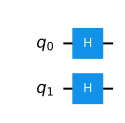

In [4]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

Wenden Sie das Orakel für $|w\rangle = |11\rangle$ an. Dieses Orakel ist spezifisch für 2 Qubits:

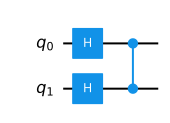

In [5]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

<span id="general_diffuser"></span>Wir wollen nun den Diffusor ($U_s$) anwenden. Wie bei der Schaltung, die $|s\rangle$ initialisiert, erstellen wir einen allgemeinen Diffusor (für eine beliebige Anzahl von Qubits), damit wir ihn später in anderen Problemen verwenden können. 

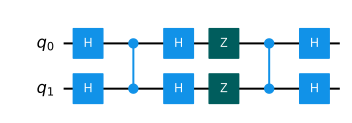

In [6]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

Dies ist unsere fertige Schaltung.

### 2.1.1 Experiment mit Simulatoren<a id="2qubits-simulation"></a>

Lassen Sie uns die Schaltung in der Simulation ausführen. Zuerst können wir überprüfen, ob wir den richtigen Zustandsvektor haben:

In [7]:
sv_sim = Aer.get_backend('statevector_simulator')
result = sv_sim.run(grover_circuit).result()
statevec = result.get_statevector()
from qiskit.visualization import array_to_latex
array_to_latex(statevec, prefix="|\\psi\\rangle =")

array([1.96261557e-16-2.46519033e-32j, 2.22044605e-16+1.22464680e-16j,
       1.96261557e-16+1.22464680e-16j, 1.00000000e+00-2.44929360e-16j])

Wie erwartet ist die Amplitude jedes Zustands, der nicht $|11\rangle$ ist, 0, was bedeutet, dass wir eine 100%ige Chance haben, $|11\rangle$ zu messen:

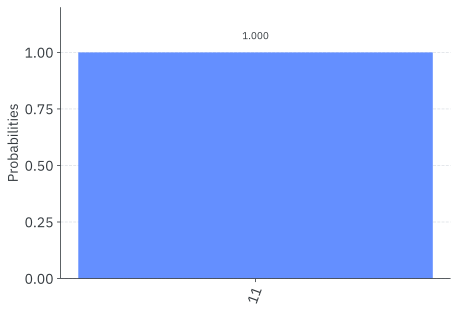

In [8]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

### 2.1.2 Experiment mit realen Geräten<a id="2qubits-device"></a>

Wir können die Schaltung mit einem echten Gerät wie unten ausführen.

In [9]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_lima


In [10]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


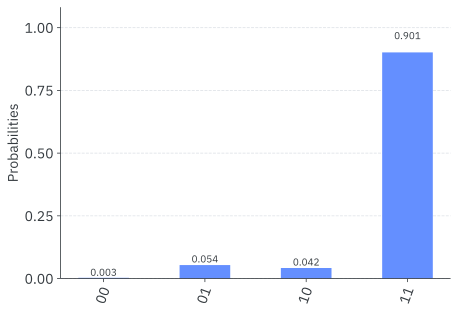

In [11]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

Wir bestätigen, dass in den meisten Fällen der Zustand $|11\rangle$ gemessen wird. Die anderen Ergebnisse sind auf Fehler in der Quantenberechnung zurückzuführen.

## 3. Beispiel: 3 Qubits<a id="3qubits"></a>

Wir gehen nun das Beispiel von Grovers Algorithmus für 3 Qubits mit zwei markierten Zuständen $\lvert101\rangle$ und $\lvert110\rangle$ durch, wobei wir der in Referenz [2] gefundenen Implementierung folgen. Die Quantenschaltung zur Lösung des Problems mit einem Phasenorakel lautet:

![Bild12](images/grover_circuit_3qubits.png)

1. Wende Hadamard-Gatter auf $3$-Qubits an, die mit $\lvert000\rangle$ initialisiert wurden, um eine einheitliche Überlagerung zu erzeugen: $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left( \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right) $$

2. Markiere Zustände $\lvert101\rangle$ und $\lvert110\rangle$ mit einem Phasenorakel: $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left( \lvert000\rangle + \ lvert001\rangle + \lvert010\rangle + \lvert011\rangle + \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right) $$

3. Führe die Reflexion um die mittlere Amplitude durch:

    1. Wende Hadamard-Gatter auf die Qubits an $$ \lvert \psi_{3a} \rangle = \frac{1}{2} \left( \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$

    2. Wende X-Gatter auf die Qubits an $$ \lvert \psi_{3b} \rangle = \frac{1}{2} \left( -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \ rechts) $$

    3. Wende ein doppelt kontrolliertes Z-Gatter zwischen den Qubits 1, 2 (Kontrollen) und 3 (Ziel) an $$ \lvert \psi_{3c} \rangle = \frac{1}{2} \left( -\lvert000\rangle +\ lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$

    4. Wende X-Gatter auf die Qubits an $$ \lvert \psi_{3d} \rangle = \frac{1}{2} \left( -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \ rechts) $$

    5. Wenden Hadamard-Gatter auf die Qubits an $$ \lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left( -\lvert101\rangle -\lvert110\rangle \right) $$

4. Messen Sie die $3$-Qubits, um die Zustände $\lvert101\rangle$ und $\lvert110\rangle$ abzurufen

Beachten Sie, dass wir, da es 2 Lösungen und 8 Möglichkeiten gibt, nur eine Iteration ausführen müssen (Schritte 2 und 3).

### 3.1 Qiskit-Implementierung<a id="3qubit-implementation"></a>

Wir implementieren nun Grovers Algorithmus für das obige [Beispiel](#3qubits) für $3$-Qubits und suchen nach zwei markierten Zuständen $\lvert101\rangle$ und $\lvert110\rangle$. **Hinweis:** Denken Sie daran, dass Qiskit seine Qubits umgekehrt zu dieser Ressource anordnet, sodass der gezeichnete Schaltkreis um die Horizontale gedreht erscheint.

Wir erstellen ein Phasenorakel, das die Zustände $\lvert101\rangle$ und $\lvert110\rangle$ als Ergebnisse markiert (Schritt 1).

In [12]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

Im letzten Abschnitt haben wir einen spezifischen Diffusor für 2 Qubits verwendet, in der Zelle darunter erstellen wir einen allgemeinen Diffusor für eine beliebige Anzahl von Qubits.

<!-- ::: q-block.reminder -->

### Detail

<summary>Erstellen eines allgemeinen Diffusors</summary>

Denken Sie daran, dass wir $U_s$ aus $U_0$ erstellen können:

$$ U_s = H^{\otimes n} U_0 H^{\otimes n} $$

Und ein mehrfach gesteuertes Z-Gatter ($MCZ$) invertiert die Phase des Zustands $|11\dots 1\rangle$:

$$ MCZ = \begin{bmatrix} 1 &amp; 0 &amp; 0 &amp; \cdots &amp; 0 \ 0 &amp; 1 &amp; 0 &amp; \cdots &amp; 0 \ \vdots &amp; \vdots &amp; \vdots &amp; \ddots &amp; \vdots \ 0 &amp; 0 &amp; 0 &amp; \cdots &amp; -1 \ \end{bmatrix} \begin{aligned} \ \ \ \leftarrow \text{Add negative phase to} ; |11\dots 1\rangle\ \end{aligned} $$

Das Anwenden eines X-Gatters auf jedes Qubit führt die Transformation durch:

$$ \begin{aligned} |00\dots 0\rangle &amp; \rightarrow |11\dots 1\rangle\ |11\dots 1\rangle &amp; \rightarrow |00\dots 0\rangle \end{aligned} $$

Also:

$$ U_0 = - X^{\otimes n} (MCZ) X^{\otimes n} $$

Wenn wir diese Eigenschaften zusammen verwenden, können wir $U_s$ mit H-Gattern, X-Gattern und einem einzelnen mehrfach gesteuerten Z-Gatter erstellen:

$$ U_s = - H^{\otimes n} U_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$

Beachten Sie, dass wir die globale Phase von -1 ignorieren können.




<!-- ::: -->

In [13]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

Nun setzen wir die Teile zusammen, indem wir am Anfang der Schaltung eine gleichmäßige Überlagerung erzeugen und am Ende eine Messung vornehmen. Beachten Sie, dass wir nur eine Iteration ausführen müssen, da es 2 Lösungen und 8 Möglichkeiten gibt. 

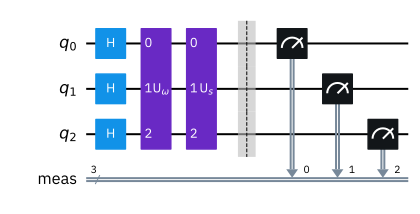

In [14]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

### 3.1.1 Experiment mit Simulatoren<a id="3qubits-simulation"></a>

Wir können die obige Schaltung auf dem Simulator ausführen. 

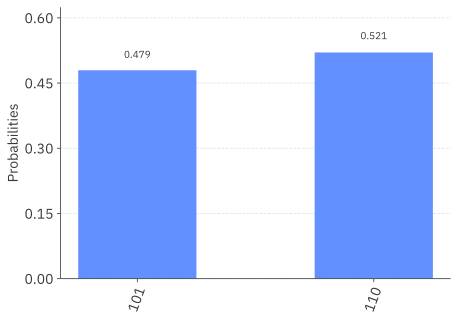

In [15]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

Wie wir sehen können, entdeckt der Algorithmus unsere markierten Zustände $\lvert101\rangle$ und $\lvert110\rangle$.

### 3.1.2 Experiment mit realen Geräten<a id="3qubits-device"></a>

Wir können die Schaltung wie folgt auf dem realen Gerät ausführen.

In [16]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [17]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


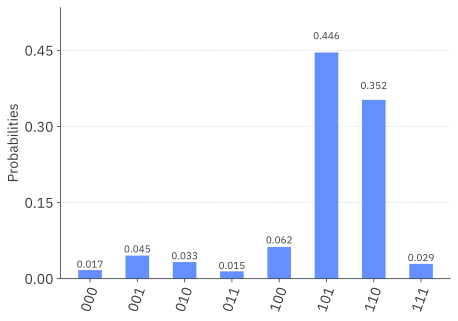

In [18]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

Wie wir (hoffentlich) sehen können, besteht eine höhere Wahrscheinlichkeit, $\lvert101\rangle$ und $\lvert110\rangle$ zu messen. Die anderen Ergebnisse sind auf Fehler in der Quantenberechnung zurückzuführen. 

## 4. Probleme<a id="problems"></a>

Die folgende Funktion `grover_problem_oracle` nimmt eine Reihe von Qubits ( `n` ) und eine `variant` und gibt ein n-Qubit-Orakel zurück. Die Funktion gibt immer dasselbe Orakel für dasselbe `n` und dieselbe `variant` zurück. Sie können die Lösungen für jedes Orakel sehen, indem Sie `print_solutions = True` setzen, wenn Sie `grover_problem_oracle` aufrufen.

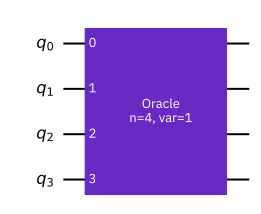

In [19]:
from qiskit_textbook.problems import grover_problem_oracle
## Example Usage
n = 4
oracle = grover_problem_oracle(n, variant=1)  # 0th variant of oracle, with n qubits
qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])
qc.draw()

1. `grover_problem_oracle(4, variant=2)` verwendet 4 Qubits und 1 Lösung.<br> A. Wie viele Iterationen benötigen wir, um diese Lösung mit einer Wahrscheinlichkeit von &gt; 90 % zu messen?<br> B. Verwenden Sie den Grover-Algorithmus, um diesen Lösungszustand zu finden. C. Was passiert, wenn wir mehr Iterationen anwenden, als wir in Aufgabe 1a oben berechnet haben? Warum?

2. Wie viele Iterationen benötigen wir bei 2 Lösungen und 4 Qubits, um mit einer Wahrscheinlichkeit von &gt;90 % eine Lösung zu messen? Testen Sie Ihre Antwort mit dem Orakel `grover_problem_oracle(4, variant=1)` (das zwei Lösungen hat).

3. Erstellen Sie eine Funktion, `grover_solver(oracle, iterations)` die folgende Eingabe verlangt:

    - Ein Grover-Orakel als Gatter ( `oracle` )
    - Eine ganze Zahl von Iterationen ( `iterations` )

    und einen `QuantumCircuit` zurück gibt, der den Grover-Algorithmus auf dem ' `oracle` -Gatter ausführt, mit ' `iterations` ' Iterationen.

## 4.1 Sudoku mit Grovers Algorithmus lösen<a id="sudoku"></a>

Die bisher in diesem Kapitel verwendeten Orakel wurden mit vorheriger Kenntnis ihrer Lösungen erstellt. Wir werden nun ein einfaches Problem mit dem Grover-Algorithmus lösen, für das wir die Lösung nicht unbedingt vorher kennen. Unser Problem ist ein 2×2 binäres Sudoku, das in unserem Fall zwei einfache Regeln hat:

- Keine Spalte darf denselben Wert zweimal enthalten
- Keine Zeile darf denselben Wert zweimal enthalten

Wenn wir jedem Quadrat in unserem Sudoku eine Variable zuweisen:

![2×2 binäres Sudoku, wobei jedes Quadrat einer anderen Variablen zugeordnet ist](images/binary_sudoku.png)

möchten wir, dass unsere Schaltung eine Lösung für dieses Sudoku ausgibt.

Beachten Sie, dass dieser Ansatz, den Grover-Algorithmus zur Lösung dieses Problems zu verwenden, zwar nicht praktikabel ist (Sie können die Lösung wahrscheinlich in Ihrem Kopf finden!), der Zweck dieses Beispiels jedoch darin besteht, die Umwandlung klassischer [Entscheidungsprobleme](https://en.wikipedia.org/wiki/Decision_problem) in Orakel für den Grover-Algorithmus zu demonstrieren.

### 4.1.1 Das Problem in einen Schaltkreis verwandeln

Wir möchten ein Orakel erstellen, das uns bei der Lösung dieses Problems hilft, und wir beginnen mit der Erstellung einer Schaltung, die eine korrekte Lösung identifiziert. Ähnlich wie wir in [*Die Atome der Berechnung*](/course/ch-states/the-atoms-of-computation) einen klassischen Addierer mit Quantenschaltkreisen erstellt haben, müssen wir einfach eine *klassische* Funktion auf einem Quantenschaltkreis erstellen, die überprüft, ob der Zustand unserer variablen Bits eine gültige Lösung ist.

Da wir beide Spalten und beide Zeilen überprüfen müssen, gibt es 4 Bedingungen, die wir überprüfen müssen:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

Denken Sie daran, dass wir klassische (Rechenbasis-)Zustände vergleichen. Der Einfachheit halber können wir diese Reihe von Vergleichen in eine Liste von Klauseln kompilieren:

In [20]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

Wir werden den Wert jeder Variablen einem Bit in unserer Schaltung zuweisen. Um diese Klauseln rechnerisch zu überprüfen, verwenden wir das `XOR` Gatter (wir sind in den Atomen der Berechnung darauf gestoßen).

In [21]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Überzeugen Sie sich selbst, dass das `output0` Bit in der folgenden Schaltung nur umgedreht wird, wenn `input0 ≠ input1` :

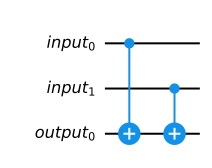

In [22]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

Diese Schaltung prüft, ob `input0 == input1` und speichert die Ausgabe in `output0` . Um jede Klausel zu überprüfen, wiederholen wir diese Schaltung für jede Paarung in `clause_list` und speichern die Ausgabe in einem neuen Bit:

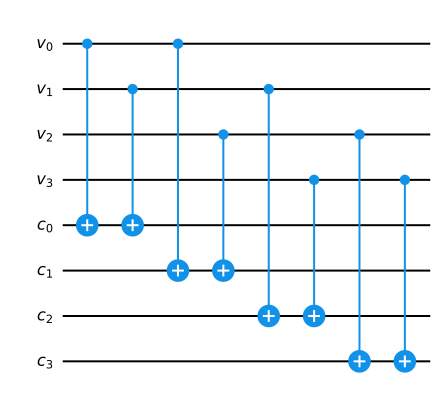

In [23]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

Der Endzustand der Bits `c0, c1, c2, c3` wird nur dann für alle `1` sein, wenn die Zuordnungen von `v0, v1, v2, v3` eine Lösung des Sudoku sind. Um unsere Prüfschaltung zu vervollständigen, möchten wir, dass ein einzelnes Bit `1` ist, wenn (und nur wenn) alle Klauseln erfüllt sind. Auf diese Weise können wir nur ein Bit betrachten, um zu sehen, ob unsere Aufgabe eine Lösung ist. Wir können dies mit einem mehrfach gesteuerten Toffoli-Gatter tun:

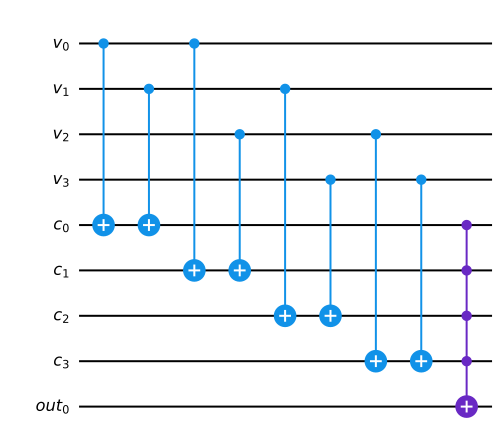

In [24]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

Die obige Schaltung nimmt als Eingabe eine anfängliche Zuweisung der Bits `v0` , `v1` , `v2` und `v3` , und alle anderen Bits sollten auf `0` initialisiert werden. Nach dem Ausführen der Schaltung sagt uns der Zustand des `out0` Bits, ob diese Zuordnung eine Lösung ist oder nicht; `out0 = 0` bedeutet, dass die Aufgabe *keine Lösung ist* , und `out0 = 1` bedeutet, dass die Aufgabe eine Lösung *ist* .

**Wichtig:** Bevor Sie fortfahren, ist es wichtig, dass Sie diese Schaltung vollständig verstehen und davon überzeugt sind, dass sie wie im obigen Absatz beschrieben funktioniert.

### 4.1.2 Rückgängigmachen und Vervollständigen des Orakels

Diese Prüfschaltung können wir nun mittels [Phasen kickback](/course/ch-gates/phase-kickback) in ein Grover-Orakel verwandeln. Um es noch einmal zusammenzufassen, wir haben 3 Register:

- Ein Register, das unsere Sudoku-Variablen speichert (wir sagen $x = v_3, v_2, v_1, v_0$)
- Ein Register, das unsere Klauseln speichert (dies beginnt im Zustand $|0000\rangle$, den wir mit $|0\rangle$ abkürzen)
- Und ein Qubit ($|\text{out}_0\rangle$), das wir verwendet haben, um die Ausgabe unserer Prüfschaltung zu speichern.

Um ein Orakel zu erstellen, brauchen wir unsere Schaltung ($U_\omega$), um die Transformation durchzuführen:

$$ U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = |x\rangle|0\rangle|\text{out}_0\oplus f(x)\rangle $$

Wenn wir das `out0` Qubit auf den Überlagerungszustand $|{-}\rangle$ setzen, haben wir:

$$ \begin{aligned} U_\omega|x\rangle|0\rangle|{-}\rangle &amp;= U_\omega|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2} }(|0\rangle - |1\rangle)\ &amp;= |x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - | 1\oplus f(x)\rangle) \end{aligned} $$

Wenn $f(x) = 0$, dann haben wir den Zustand:

$$ \begin{aligned} &amp;= |x\rangle|0\rangle\otimes \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\ &amp;= |x\rangle| 0\rangle|-\rangle\ \end{aligned} $$

(d.h. keine Änderung). Aber wenn $f(x) = 1$ (dh $x = \omega$), führen wir eine negative Phase in das $|{-}\rangle$ Qubit ein:

$$ \begin{aligned} &amp;= \phantom{-}|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|1\rangle - |0\rangle)\ &amp;= \phantom{-}|x\rangle|0\rangle\otimes -\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\ &amp;= -|x\rangle|0\ range|-\rangle\ \end{aligned} $$

Dies ist ein funktionierendes Orakel, das zwei Hilfsregister im Zustand $|0\rangle|{-}\rangle$ verwendet:

$$ U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg{ \begin{aligned} \phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{ für} ; x\neq\omega\-|x\rangle|0\rangle|-\rangle\quad\text{für} ; x = \omega \ \end{aligned} $$

Um unsere Prüfschaltung an ein Grover-Orakel anzupassen, müssen wir sicherstellen, dass die Bits im zweiten Register ( `c` ) nach der Berechnung immer in den Zustand $|0000\rangle$ zurückkehren. Dazu wiederholen wir einfach den Teil der Schaltung, der die Klauseln berechnet, die `c0 = c1 = c2 = c3 = 0` garantieren, nachdem unsere Schaltung gelaufen ist. Wir nennen diesen Schritt *„uncomputation“* .

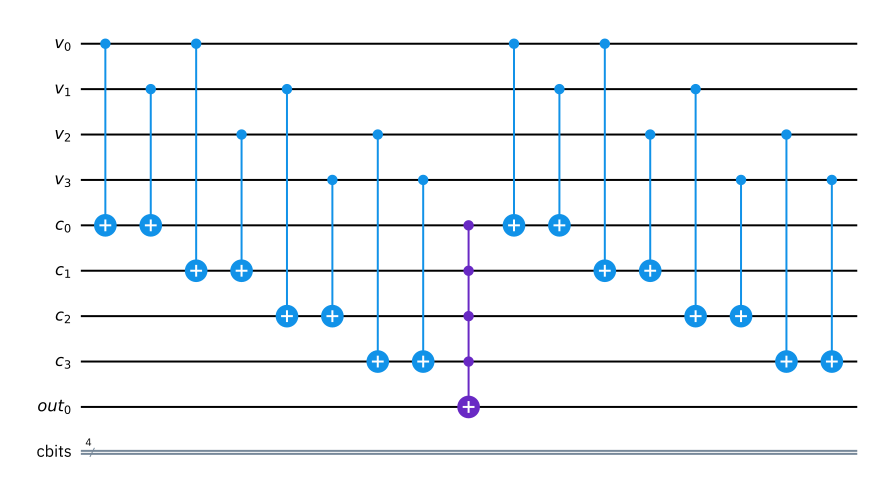

In [25]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

Zusammenfassend führt dies die obige Schaltung aus:

$$ U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg{ \begin{aligned} |x\rangle|0\rangle|\text{out}_0\rangle \quad \text{für} ; x \neq \omega \ |x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} ; x = \omega \ \end{aligned} $$

und wenn der Anfangszustand von $|\text{out}_0\rangle = |{-}\rangle$,:

$$ U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg{ \begin{aligned} \phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{ für} ; x\neq\omega\-|x\rangle|0\rangle|-\rangle\quad\text{für} ; x = \omega \ \end{aligned} $$

### 4.1.3 Der vollständige Algorithmus

Jetzt müssen nur noch all diese Komponenten zusammengefügt werden.

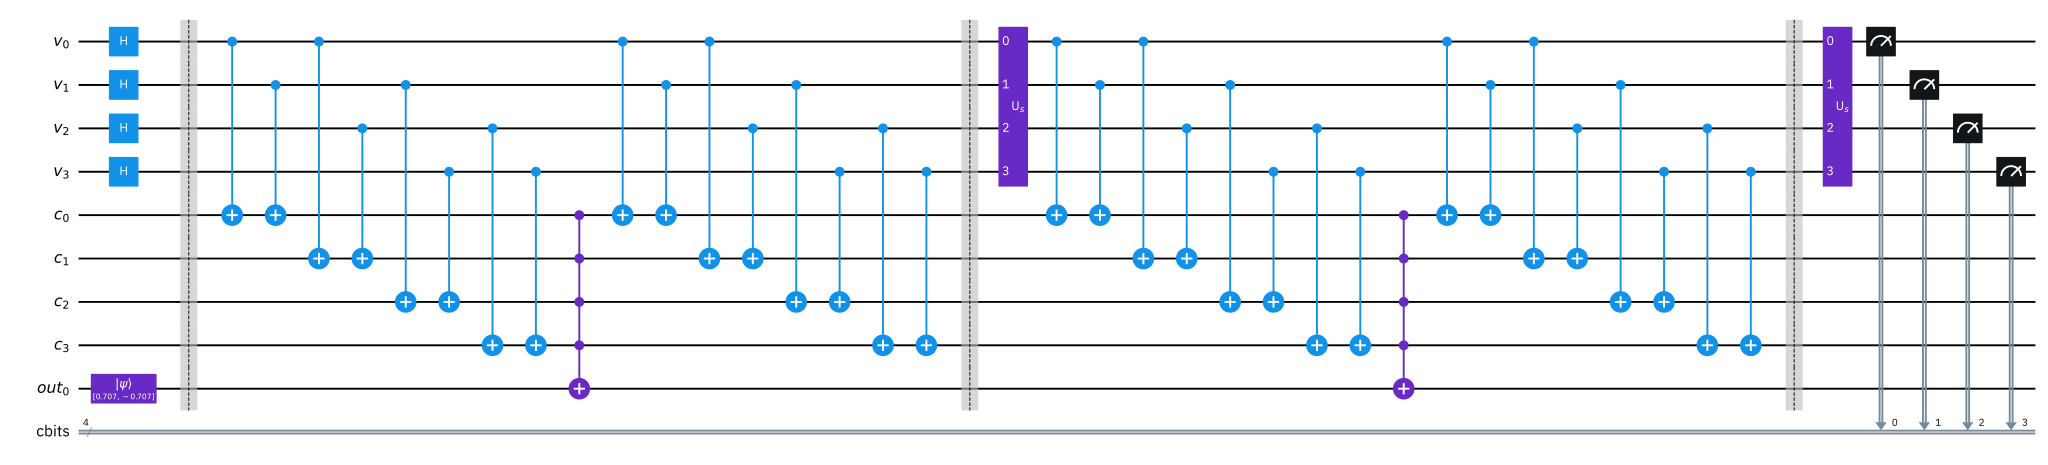

In [26]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

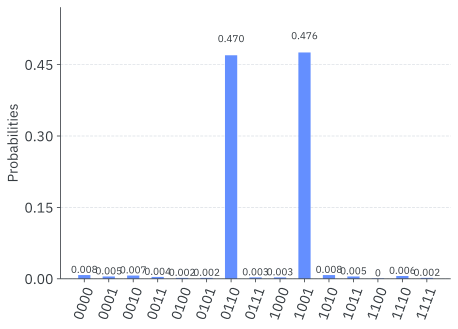

In [27]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

Es gibt zwei Bitfolgen mit einer viel höheren Messwahrscheinlichkeit als alle anderen, `0110` und `1001` . Diese entsprechen den Aufgaben:

```
v0 = 0
v1 = 1
v2 = 1
v3 = 0
```

Und

```
v0 = 1
v1 = 0
v2 = 0
v3 = 1
```

Das sind die beiden Lösungen für unser Sudoku! Das Ziel dieses Abschnitts ist es zu zeigen, wie wir Grover-Orakel aus realen Problemen erstellen können. Während dieses spezifische Problem trivial ist, kann der Prozess auf jedes Entscheidungsproblem angewendet werden (wobei ausreichend große Schaltungen zugelassen werden). Um es noch einmal zusammenzufassen, die Schritte sind:


 

<!-- ::: q-block.exercise -->

### Du bist dran

1. Erstelle eine umkehrbare klassische Schaltung, die eine korrekte Lösung identifiziert
2. Verwende den Phasen Kickback und Uncomputation, um diese Schaltung in ein Orakel zu verwandeln
3. Verwende Grovers Algorithmus, um dieses Orakel zu lösen

<!-- ::: -->


## 4.2 Das Dreiecksfindungsproblem mit Grover<a id="tri"></a>

Eines der bekanntesten Probleme [der Graphentheorie](gloss:gt) ist das [Dreiecksfindungsproblem](https://en.wikipedia.org/wiki/Triangle-free_graph) . Beim Dreiecksfindungsproblem erhalten wir einen Graphen, der ein Dreieck enthalten kann oder nicht. Unsere Aufgabe ist es, das/die Dreieck(e) innerhalb des Graphen zu finden und auf die Knoten hinzuweisen, die das Dreieck bilden. Das folgende Diagramm ist beispielsweise ein 4-Knoten-Diagramm mit einem Dreieck zwischen den Knoten `0` , `1` und `2` .

![Bild12](images/grover_tri.png)

Wir können Grovers Algorithmus auf dieses Problem anwenden, wir geben dem Algorithmus eine Liste von *Kanten* und die Anzahl von Knoten im Graphen. Den Rest erledigt dann der Algorithmus. Er versucht zu überprüfen, ob es ein Dreieck im Diagramm gibt oder nicht, und wenn ja, markiert er die Knoten, die dieses Dreieck bilden.

Lassen Sie uns nun Grovers Algorithmusschritte durchgehen und sehen, wie wir jeden Schritt konstruieren können, um das Dreiecksfindungsproblem zu lösen. Aber zuerst definieren wir unsere Eingabe, die die Liste der Kanten ist.

In [28]:
#Edges list
edges =[(0, 1), (0, 2), (1, 2), (2, 3)]
#Number of nodes
n_nodes = 4

### 4.2.1 Die Zustandsvorbereitung

Um das Problem zu lösen, konzentrieren wir uns zunächst auf das obige Beispiel, bei dem es darum geht, ein Dreieck in einem 4-Knoten-Diagramm zu finden. Dazu müssen wir alle Teilgraphen in unserem Graphen durchgehen und prüfen, ob einer von ihnen ein Dreieck ist. Dazu benötigen wir 4 Qubits, wobei jedes Qubit einen Knoten im Diagramm darstellt. Der Zustand des Qubits gibt an, ob sich der Knoten in einem Teilgraphen befindet oder nicht. In der obigen Grafik befindet sich das Dreieck beispielsweise zwischen den Knoten 0, 1 und 2. Wir können dies mit dem Zustand `1110` umformulieren. Die Knoten mit Zustand 1 befinden sich im Teilgraphen (Dreieck) und der Knoten mit Zustand 0 nicht.

Für die Zustandsvorbereitung müssen wir eine Überlagerung aller möglichen Zustände `0000` bis `1111` erstellen, was einfach mit `4` Hadamard-Gattern erfolgen kann. Dazu müssen wir `3` mal über das Orakel und die Diffusion rotieren.<br> Aber wenn jede `1` im Zustand einen aktiven Knoten darstellt, müssen wir nicht wirklich den gesamten Hilbert-Raum durchsehen, wir müssen nur die Teilgraphen mit drei Knoten durchsehen.

Dies ist ein gutes Beispiel für die Verwendung einer anderen Art von symmetrischen Zuständen, um den Suchraum vorzubereiten. Da wir hier nur Zustände mit drei Einsen betrachten müssen, können wir uns eine andere Möglichkeit vorstellen, unseren Suchraum zu bilden. Eine Möglichkeit, eine Überlagerung nur über Zustände mit drei aktiven Knoten zu erzeugen, besteht darin, den W-Zustand gefolgt von `4 NOT gates` zu verwenden. Dadurch verringert sich die Anzahl der erforderlichen Umdrehungen von `3` auf `1` .

Also müssen wir zuerst den W-Zustand implementieren. W-Zustände haben die Form:

$$

In unserem Fall müssen wir $|W_{3}\rangle$-Zustände konstruieren, wie in Referenz 6 beschrieben.

In [29]:
#We used the W state implementation from W state in reference 6
def control_rotation (qcir,cQbit,tQbit,theta):
    """ Create an intermediate controlled rotation using only unitary gate and controlled-NOT
    
    Args:
    qcir: QuantumCircuit instance to apply the controlled rotation to.
    cQbit: control qubit. 
    tQbit: target qubit.
    theta: rotation angle.
    
    Returns:
    A modified version of the QuantumCircuit instance with control rotation applied.
    
    """
    theta_dash = math.asin(math.cos(math.radians(theta/2)))
    qcir.u(theta_dash,0,0,tQbit)
    qcir.cx(cQbit,tQbit)
    qcir.u(-theta_dash,0,0,tQbit)
    return qcir


def wn (qcir,qbits): 
    """ Create the W-state using the control-rotation function.
    
    Args:
    qcir: QuantumCircuit instance used to construct the W-state.
    qbits: the qubits used to construct the W-state.
    
    Returns:
    A modified version of the QuantumCircuit instance with the W-state construction gates.
    
    """
    for i in range(len(qbits)):
        if i == 0:
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            p = 1/(len(qbits)-(i-1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2* theta
            qcir = control_rotation(qcir,qbits[i-1],qbits[i],theta)
            qcir.cx(qbits[i],qbits[i-1])
            qcir.barrier()
    return qcir,qbits

sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits, name="state_prep")
sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
sub_cir.x(sub_qbits)
stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()

### 4.2.2 Das Orakel

Das Orakel wird die richtige Antwort markieren. In diesen Fällen muss das Orakel jeden Untergraphen nehmen und die Anzahl der Kanten in diesem Untergraphen zählen. Wenn die Anzahl der Kanten `3` ist, dann haben wir ein Dreieck, wenn nicht, geht es zum nächsten Teilgraphen.

![Bild13](images/grover_tri_oracle.png)

Für jede Kante im Diagramm benötigen wir ein oder zwei `CNOT` Gatter. Diese `CNOT` Gatter gelten für zwei Hilfs-Qubits, die sich im Zustand `11` befinden sollten, wenn ein Dreieck gefunden wird. Die Anzahl der Hilfs-Qubits beträgt hier zwei, da ein Dreieck `3 Kanten` hat, also $11_{b}$. Dann besteht der letzte Schritt im Orakel darin, ein weiteres `Toffoli` anzuwenden, das nur aktiv wird, wenn ein Dreieck gefunden wird, indem der Zustand eines anderen Qubits, nennen wir es `tri_flag` , auf `1` geändert wird.

 

<!-- ::: q-block.reminder -->

### Erinnerung


<summary>Orakel</summary> Die Aufgabe des Orakels besteht darin, die richtige Antwort zu überprüfen und zu markieren. Wenn Sie also ein Orakel konstruieren, bauen Sie im Grunde einen Schaltkreis, um bestimmte Bedingungen zu überprüfen.

<!-- ::: -->

In [30]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    qc.mct(l,flag_qubit,[anc])
    
    
def oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):
    k = 3 #k is the number of edges, in case of a triangle, it's 3
    #1- edge counter
    #forward circuit
    qc.barrier()
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0]], edge_anc[1], [ancilla[0]])
        qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0])
    #----------------------------------------------------------------------------------------------------------
     #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[0],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------

    #4- Reverse edge count
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0]], edge_anc[1], [ancilla[0]])
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    qc.barrier()

### 4.2.3 Der Diffusionsoperator

Wie wir bereits gesagt haben, hängt die Konstruktion des Diffusionsoperators von der Art der Zustandsvorbereitung ab, die wir verwendet haben, in diesem Fall dem W-Zustand. Wir brauchen also den inversen W-Zustand, ein mehrfach gesteuertes Z-Gatter und den ursprünglichen W-Zustand, um den Diffusionsoperator zu bilden.

In [31]:
def cnz(qc, num_control, node, anc):
    """Construct a multi-controlled Z gate
    
    Args:
    num_control :  number of control qubits of cnz gate
    node :             node qubits
    anc :               ancillaly qubits
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

In [32]:
def grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep):
    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits) 

### 4.2.4 Alles zusammenfügen

Nachdem wir nun alle Komponenten des Algorithmus erstellt und ausgeführt haben, können wir sie zusammensetzen.

In [33]:
# Grover algo function
def grover(n_nodes,stat_prep,inv_stat_prep):
    #N = 2**n_nodes  # for optimal iterations count if the state prep is done using only H gates.
    N = math.comb(n_nodes, 3) #Since we are using W-state to perform initial preparation.
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(2, name='edge_anc')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(3, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base[0])
    qc.h(neg_base[0])
    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    iterations = math.floor(math.pi/4*math.sqrt(N))
    # Calculate iteration count
    for i in np.arange(iterations):
        qc.barrier()
        oracle(n_nodes, edges, qc, nodes_qubits, edge_anc,  ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    return qc

Lassen Sie uns nun den Code ausführen und das Histogramm zeichnen, um zu sehen, ob unser Algorithmus wie erwartet funktioniert.

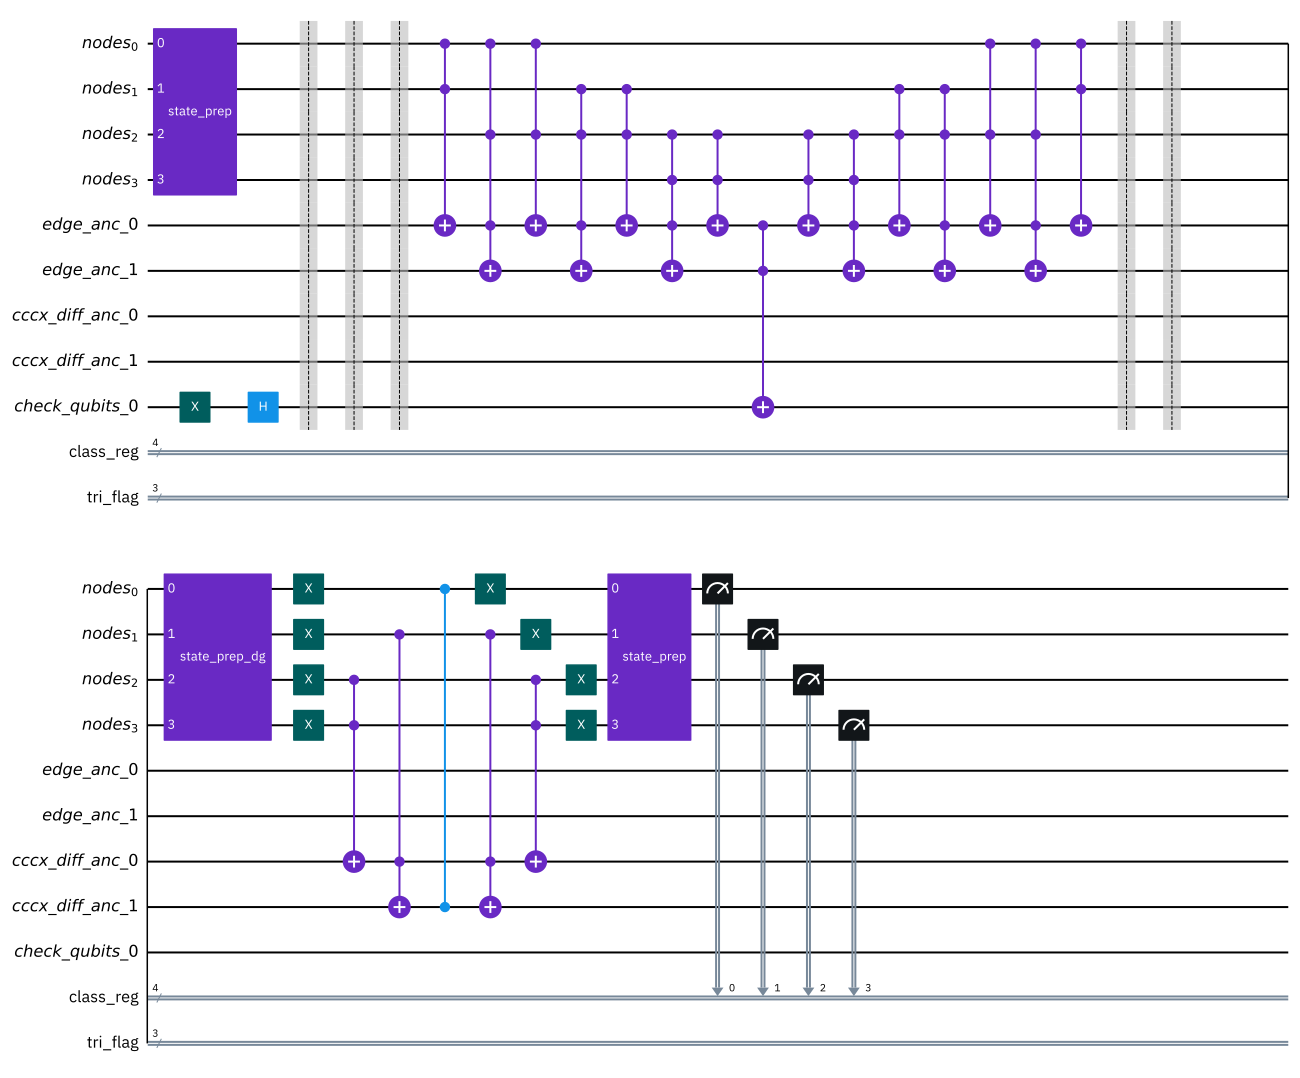

In [34]:
qc = grover(n_nodes,stat_prep,inv_stat_prep)
qc.draw()

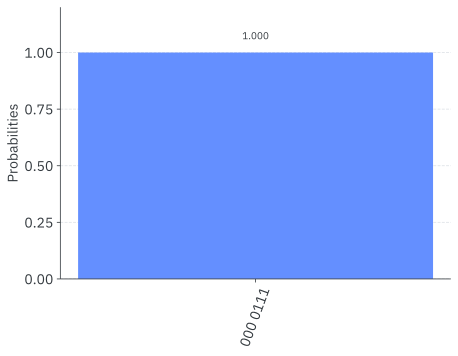

In [35]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
#transpiled_qc = transpile(qc, qasm_simulator)
# Execute circuit and show results
ex = execute(qc, qasm_simulator, shots = 5000)
res = ex.result().get_counts(qc)
plot_histogram(res)

<!-- ::: q-block.exercise -->

### Du bist dran

Können Sie dieses Problem erweitern, um ein Dreieck in einem Graphen beliebiger Größe zu finden?

Versuchen Sie es in [IBM Quantum Lab](https://quantum-computing.ibm.com/lab)

<!-- ::: -->


## 5. Referenzen<a id="references"></a>

1. LK Grover (1996), „Ein schneller quantenmechanischer Algorithmus für die Datenbanksuche“, Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996), [doi:10.1145/237814.237866](http://doi.acm.org/10.1145/237814.237866) , [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)
2. C. Figgatt, D. Maslov, KA Landsman, NM Linke, S. Debnath &amp; C. Monroe (2017), „Complete 3-Qubit Grover search on a programmierbar quanten computer“, Nature Communications, Bd. 8, Art. 1918, [doi: 10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7) , [arXiv:1703.10535](https://arxiv.org/abs/1703.10535)
3. I. Chuang &amp; M. Nielsen, „Quantum Computation and Quantum Information“, Cambridge: Cambridge University Press, 2000.
4. Marconi, C., Aloy, A., Tura, J., &amp; Sanpera, A. (2021). Verschränkte symmetrische Zustände und kopositive Matrizen. Quantum, 5, 561.
5. R. Prevedel, G. Cronenberg, MS Tame, M. Paternostro, P. Walther, MS Kim und A. Zeilinger, „Experimentelle Realisierung von Dicke-Zuständen von bis zu sechs Qubits für Mehrparteien-Quantennetzwerke“, Physical Review Letters, vol. 103, Nr. 2. Juli 2009.
6. D. Cruz, R. Fournier, F. Gremion, A. Jeannerot, K. Komagata, T. Tosic, J. Thiesbrummel, CL Chan, N. Macris, M.-A. Dupertuis et al., „Effiziente Quantenalgorithmen für ghz- und w-Zustände und Implementierung auf dem IBM-Quantencomputer“, Advanced Quantum Technologies, vol. 2, nein. 5-6, S. 1900015, 2019. https://doi.org/10.1002/qute.201900015
7. Magniez, F., Santha, M., &amp; Szegedy, M. (2007). Quantenalgorithmen für das Dreiecksproblem. SIAM Journal on Computing, 37(2), 413-424.

In [36]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
